In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.neighbors import LocalOutlierFactor
import datetime
import warnings

from pathlib import Path
DATA_PATH = Path("..") / "housing.csv"
df = pd.read_csv(DATA_PATH)

/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.shape

(20640, 10)

## Data Cleaning

In [5]:
df['ocean_proximity'].replace({'NEAR BAY': 1,  'INLAND': 2, 'ISLAND':3, '<1H OCEAN': 4,'NEAR OCEAN': 5}, inplace=True)
df.head()

/var/folders/q_/v6073c7179x4wk0ftwdqqk6c0000gn/T/ipykernel_16650/1837242499.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ocean_proximity'].replace({'NEAR BAY': 1,  'INLAND': 2, 'ISLAND':3, '<1H OCEAN': 4,'NEAR OCEAN': 5}, inplace=True)
/var/folders/q_/v6073c7179x4wk0ftwdqqk6c0000gn/T/ipykernel_16650/1837242499.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the fu

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1


### Deleting Missing values

In [6]:
df=df.dropna()

In [7]:
df.shape

(20433, 10)

### Check duplicates

In [8]:
df = df.drop_duplicates(keep='first')
df.shape

(20433, 10)

### Delete extreme data (outliers)

#### Statistical Methods (z-scores)

In [9]:
# box visualization
df_mean=df.mean()
df_std=df.std()
df_max=df.max()
df_min=df.min()
##count numbers
data = pd.DataFrame({
    'mean':df_mean,
    'std':df_std,
    'max':df_max,
    'min':df_min,
    })
display(data)
print(data.to_latex(index = True, multirow = True)) 

,mean,std,max,min
longitude,-119.570689,2.003578,-114.3100,-124.3500
latitude,35.633221,2.136348,41.9500,32.5400
housing_median_age,28.633094,12.591805,52.0000,1.0000
total_rooms,2636.504233,2185.269567,39320.0000,2.0000
total_bedrooms,537.870553,421.385070,6445.0000,1.0000
population,1424.946949,1133.208490,35682.0000,3.0000
households,499.433465,382.299226,6082.0000,1.0000
median_income,3.871162,1.899291,15.0001,0.4999
median_house_value,206864.413155,115435.667099,500001.0000,14999.0000
ocean_proximity,3.159252,1.301387,5.0000,1.0000


\begin{tabular}{lrrrr}
\toprule
 & mean & std & max & min \\
\midrule
longitude & -119.570689 & 2.003578 & -114.310000 & -124.350000 \\
latitude & 35.633221 & 2.136348 & 41.950000 & 32.540000 \\
housing_median_age & 28.633094 & 12.591805 & 52.000000 & 1.000000 \\
total_rooms & 2636.504233 & 2185.269567 & 39320.000000 & 2.000000 \\
total_bedrooms & 537.870553 & 421.385070 & 6445.000000 & 1.000000 \\
population & 1424.946949 & 1133.208490 & 35682.000000 & 3.000000 \\
households & 499.433465 & 382.299226 & 6082.000000 & 1.000000 \\
median_income & 3.871162 & 1.899291 & 15.000100 & 0.499900 \\
median_house_value & 206864.413155 & 115435.667099 & 500001.000000 & 14999.000000 \\
ocean_proximity & 3.159252 & 1.301387 & 5.000000 & 1.000000 \\
\bottomrule
\end{tabular}



#### 1. 5 IQR

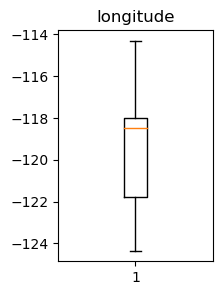

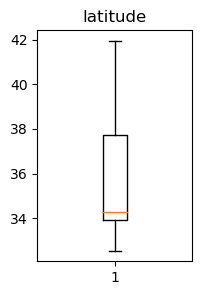

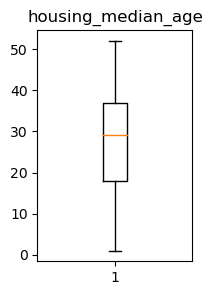

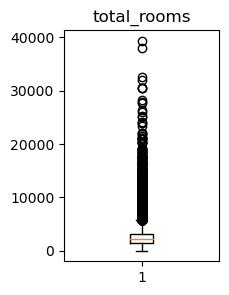

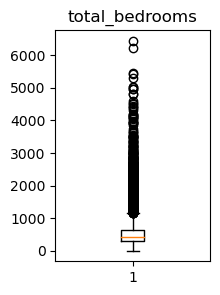

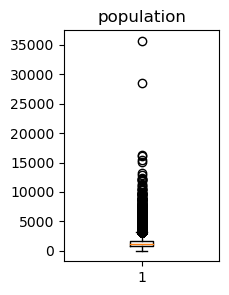

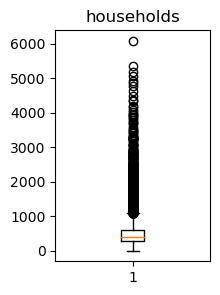

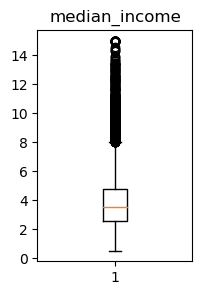

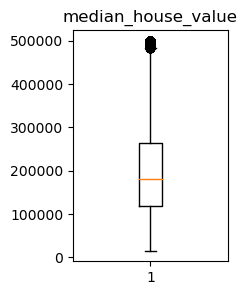

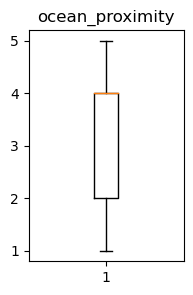

In [10]:
# Creating box plot
for i in range(10):
    fig = plt.figure(figsize =(2, 3))
    plt.boxplot(df.iloc[:,i])
    plt.title(df.columns[i])
plt.show()   
    
# skew to the right

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

replacement:

$${RoomsPer}=\frac{totalRooms}{population}$$

$${PerBedroom}=\frac{population}{totalBedrooms}$$

$${MemberNum}=\frac{population}{households}$$

$${IncomerPer}=\frac{medianIncome}{MemberNum}$$

$${PricePer}=\frac{medianHouseValue}{MemberNum}$$




0        2.732919
1        2.956685
2        2.957661
3        2.283154
4        2.879646
           ...   
20635    1.970414
20636    1.957865
20637    2.238332
20638    2.510121
20639    2.007931
Length: 20433, dtype: float64

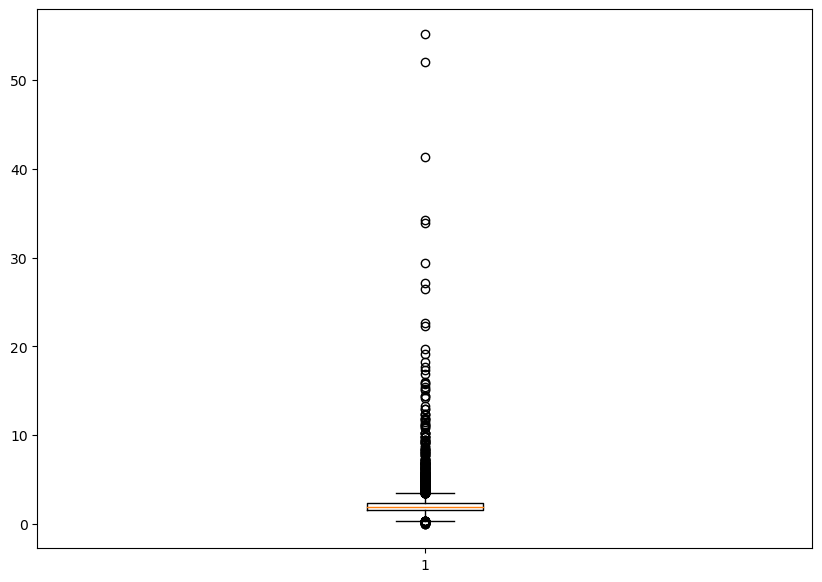

In [11]:
RoomsPer=df['total_rooms']/df['population']
display(RoomsPer)
fig = plt.figure(figsize =(10, 7))
plt.boxplot(RoomsPer)
plt.show()

### Correct outliers

lof(Local Outlier Factor)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

y=df['median_house_value']
X=df.drop('median_house_value',axis='columns')
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
y_pred=clf.fit_predict(X)
mask = y_pred != -1

In [13]:
X_filtered = X[mask]
y_filtered = y[mask]

In [14]:
y_filtered.shape

(19411,)

In [15]:
df_filtered=pd.concat([X_filtered, y_filtered],axis=1)
df_filtered.shape

(19411, 10)

### Remove irrelevant data Or Reduce dimension

#### Correlation

In [16]:
corr_matrix = df.corr()
print(corr_matrix)

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924616           -0.109357     0.045480   
latitude            -0.924616  1.000000            0.011899    -0.036667   
housing_median_age  -0.109357  0.011899            1.000000    -0.360628   
total_rooms          0.045480 -0.036667           -0.360628     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.100270 -0.108997           -0.295787     0.857281   
households           0.056513 -0.071774           -0.302768     0.918992   
median_income       -0.015550 -0.079626           -0.118278     0.197882   
median_house_value  -0.045398 -0.144638            0.106432     0.133294   
ocean_proximity      0.395270 -0.552480           -0.010830    -0.003958   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.100270    0.056513      -0.015550   
latitude 

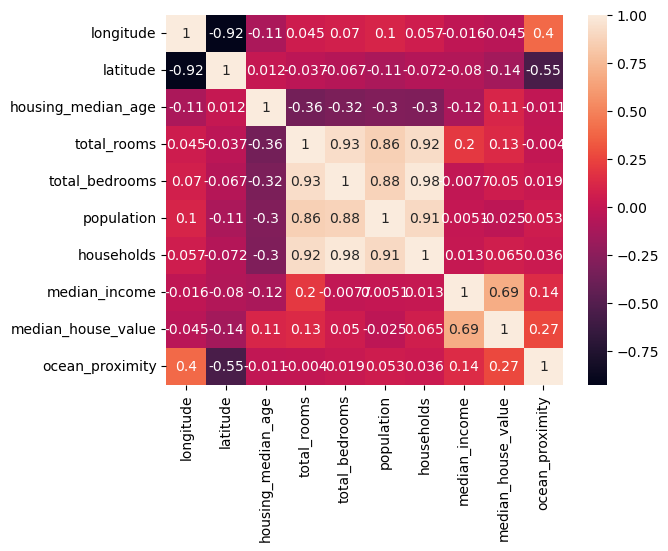

In [17]:
#??? a map required here
sns.heatmap(df.corr(),annot=True)
plt.show()

longitude vs latitude: CA
longitude & latitude vs others(including price): abs(0.15) 
rooms vs bedrooms vs pop vs households
population lowest
income: may contribute the most

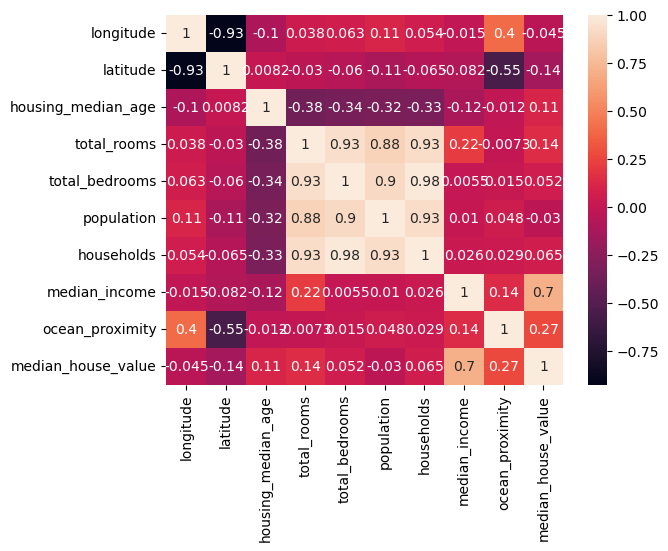

In [18]:
corr_filtered = df_filtered.corr()
sns.heatmap(corr_filtered,annot=True)
plt.show()

won't affect the correlation

In [19]:
updated_X=X_filtered.drop('longitude',axis='columns')
updated_X=updated_X.drop('total_bedrooms',axis='columns')
updated_X=updated_X.drop('population',axis='columns')
updated_X=updated_X.drop('households',axis='columns')

In [20]:
print(updated_X)

       latitude  housing_median_age  total_rooms  median_income  \
0         37.88                41.0        880.0         8.3252   
1         37.86                21.0       7099.0         8.3014   
2         37.85                52.0       1467.0         7.2574   
3         37.85                52.0       1274.0         5.6431   
4         37.85                52.0       1627.0         3.8462   
...         ...                 ...          ...            ...   
20635     39.48                25.0       1665.0         1.5603   
20636     39.49                18.0        697.0         2.5568   
20637     39.43                17.0       2254.0         1.7000   
20638     39.43                18.0       1860.0         1.8672   
20639     39.37                16.0       2785.0         2.3886   

       ocean_proximity  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
20635               

#### Principal Component Analysis

In [21]:
from sklearn.decomposition import PCA

#7 much more better than 6 (goes from approx 0.2 to approx0.6)
pca = PCA(n_components = 5)
new_X=pca.fit_transform(X)

print(new_X)
ratios = pca.explained_variance_ratio_
ratios

[[-2.13081209e+03 -2.53038904e+02  6.39160794e+01 -5.40258179e+00
   9.08787927e+00]
 [ 4.52887379e+03 -1.03306780e+03  3.58553438e+01 -1.34000371e+02
   7.44734097e-02]
 [-1.52310437e+03 -3.52451588e+02  1.07966394e+02 -4.97630055e+00
   2.15397032e+01]
 ...
 [-5.30217412e+02 -2.09577975e+02 -5.58165621e+01  3.38606206e+00
  -1.23820401e+01]
 [-1.01343436e+03 -2.82076123e+02 -5.65372070e+01  1.17358996e+01
  -1.20019055e+01]
 [ 1.32261438e+02 -9.29739972e+01 -6.19461252e+01  2.38591025e+01
  -1.20377344e+01]]


array([9.50256818e-01, 4.46105530e-02, 4.68016588e-03, 4.29118154e-04,
       2.14093704e-05])

In [22]:
fpca = PCA(n_components = 7)

new_f_X=fpca.fit_transform(X_filtered)

print(new_f_X)
f_ratios = fpca.explained_variance_ratio_
f_ratios

[[-2.09404962e+03  2.66948426e+02  5.10147872e+01 ...  8.36257671e+00
   2.93421301e+00  3.79574880e+00]
 [ 4.57270281e+03  9.84258947e+02 -9.66649851e+00 ...  6.06974826e-03
   2.37810049e+00  8.44220628e-01]
 [-1.48540942e+03  3.62279059e+02  9.09312480e+01 ...  2.09805724e+01
   2.88938600e+00  2.45073532e+00]
 ...
 [-4.94064481e+02  2.04307591e+02 -6.83140353e+01 ... -1.26819889e+01
   4.12938295e+00 -1.88333921e+00]
 [-9.76606678e+02  2.81166820e+02 -7.13764927e+01 ... -1.23853930e+01
   4.08769958e+00 -1.67891518e+00]
 [ 1.67271601e+02  8.13645795e+01 -7.08239576e+01 ... -1.19963234e+01
   4.26104334e+00 -8.86379685e-01]]


array([9.58218444e-01, 3.75425485e-02, 3.86498216e-03, 3.46996624e-04,
       2.47854171e-05, 1.57897468e-06, 4.15229287e-07])

In [23]:
new_X.shape

(20433, 5)

## Regression models

In [24]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def performance(y_test, y_pred):
    mae=mean_absolute_error(y_test, y_pred)
    mse=mean_squared_error(y_test, y_pred)
    rmse=sqrt(mean_squared_error(y_test, y_pred))
    r2=r2_score(y_test, y_pred)
    print(mae)
    print(mse)
    print(rmse)
    print(r2)
    return

In [25]:
from sklearn.metrics import mean_absolute_percentage_error

### Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered,y_filtered,test_size = 0.20)
# del closely correlation directly:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(updated_X,y_filtered,test_size = 0.20)
# pca
X_train_fp, X_test_fp, y_train_fp, y_test_fp = train_test_split(new_f_X,y_filtered,test_size = 0.20)

In [27]:
# Define a function to perturb the entire dataset
def perturb_dataset(X, noise_level):
    noise = np.random.normal(0, noise_level, X.shape)
    X_perturbed = X + noise
    return X_perturbed

def perturbationDisplay(model, Xtest, ytest, y_pred):
    baseline_mape = mean_absolute_percentage_error(ytest, y_pred)
    print(baseline_mape)
    # Perturbation levels (e.g., standard deviations of the noise added)
    noise_levels = np.linspace(0.01, 0.2, 10)  # from 1% to 20% noise

    # List to store results
    sensitivity_results = []

    # Perform global sensitivity analysis
    for noise_level in noise_levels:
        X_perturbed = perturb_dataset(Xtest.values, noise_level)
        y_pred_perturbed = model.predict(X_perturbed)
    
        mape = mean_absolute_percentage_error(ytest, y_pred_perturbed)
    
        sensitivity_results.append({
            'noise_level': noise_level,
            'MAPE': mape
        })

    # Convert results to a DataFrame
    sensitivity_df = pd.DataFrame(sensitivity_results)
    print(sensitivity_df)



    plt.figure(figsize=(10, 6))
    plt.plot(sensitivity_df['noise_level'], sensitivity_df['MAPE'], marker='o', label='MAPE')
    plt.title('Model Sensitivity to Perturbations in the Entire Dataset')
    plt.xlabel('Noise Level')
    plt.ylabel('Performance Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

0.32970259925768347
   noise_level      MAPE
0     0.010000  0.329723
1     0.031111  0.329773
2     0.052222  0.330161
3     0.073333  0.329874
4     0.094444  0.330770
5     0.115556  0.330305
6     0.136667  0.330397
7     0.157778  0.332480
8     0.178889  0.331949
9     0.200000  0.332843


/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/a

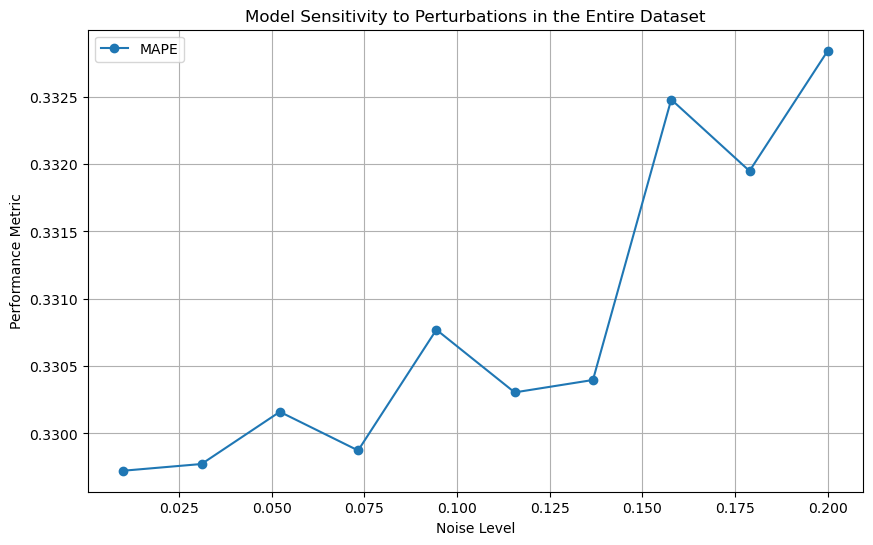

57446.02513889468
5985624667.351552
77366.81890417592
0.5483334042011938


0.5483334042011938

In [28]:
def linearReg(Xtrain, Xtest, ytrain, ytest):
    model = LinearRegression().fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    perturbationDisplay(model, Xtest, ytest, y_pred)
    performance(ytest, y_pred)
    
    return model.score(Xtest,ytest)

linearReg(X_train_u, X_test_u, y_train_u, y_test_u )

### Polynomial Regression

In [29]:
from sklearn.preprocessing import PolynomialFeatures

def polyReg(Xtrain, Xtest, ytrain, ytest):
    poly = PolynomialFeatures(degree=3)
    X_p_train = poly.fit_transform(Xtrain)
    X_p_test = poly.fit_transform(Xtest)

  #  y_p_test = poly.fit_transform(ytest)
    model = LinearRegression()
    model.fit(X_p_train, ytrain)
    y_pred = model.predict(X_p_test)
    performance(ytest, y_pred)
    return model.score(X_p_test,ytest)

polyReg(X_train_f, X_test_f, y_train_f, y_test_f)

37755.14613479701
3232343624.1333065
56853.70369758954
0.7617997925125439


0.7617997925125439

### Support Vector Regression (SVR)

In [30]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def svReg(Xtrain, Xtest, ytrain, ytest):
    model = make_pipeline(StandardScaler(), SVR(kernel='linear',gamma='auto',epsilon=0.1))
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    return model.score(Xtrain,ytrain)

svReg(X_train_f, X_test_f, y_train_f, y_test_f)

0.06705765027131139

### Decision Tree Regression

0.2895594426947961
   noise_level      MAPE
0     0.010000  0.295529
1     0.031111  0.314468
2     0.052222  0.314548
3     0.073333  0.328349
4     0.094444  0.326554
5     0.115556  0.329857
6     0.136667  0.329028
7     0.157778  0.352650
8     0.178889  0.348265
9     0.200000  0.343668


/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.w

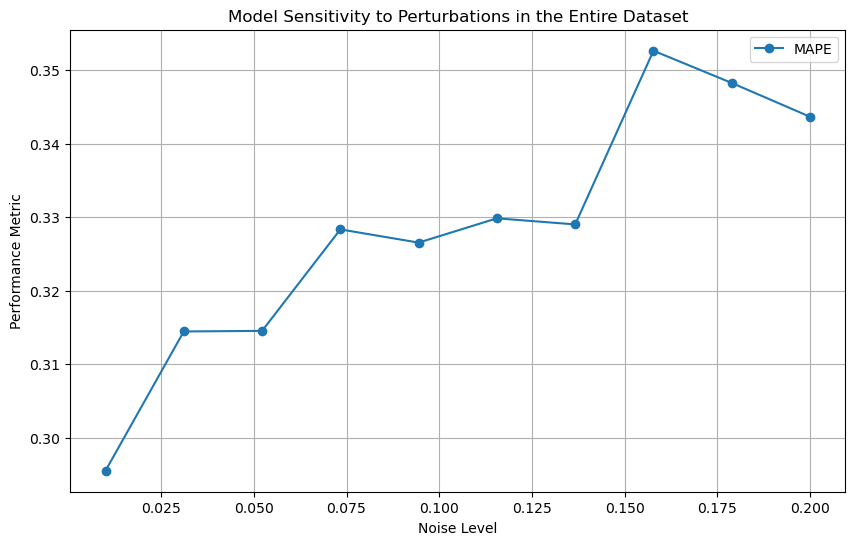

[0.13342358 0.08436848 0.09026079 0.56787851 0.12406863]
54899.91449909863
6792244994.789596
82415.07747244794
0.4874669988311322


0.4874669988311322

In [31]:
from sklearn.tree import DecisionTreeRegressor  

def dtReg(Xtrain, Xtest, ytrain, ytest):
    model=DecisionTreeRegressor()
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    perturbationDisplay(model, Xtest, ytest, y_pred)
    print(model.feature_importances_)
    performance(ytest, y_pred)
    return model.score(Xtest,ytest)

dtReg(X_train_u, X_test_u, y_train_u, y_test_u)

### Random Forest Regression

0.1730034410045778


/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.w

   noise_level      MAPE
0     0.010000  0.178065
1     0.031111  0.198951
2     0.052222  0.217123
3     0.073333  0.226694
4     0.094444  0.245453
5     0.115556  0.249156
6     0.136667  0.259121
7     0.157778  0.271948
8     0.178889  0.279549
9     0.200000  0.284114


/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


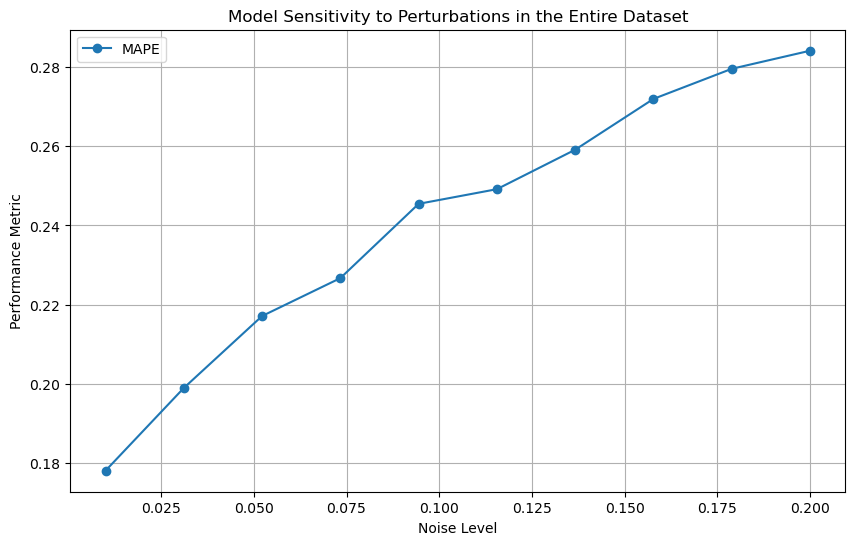

[0.13078944 0.09856527 0.04995109 0.02445613 0.02051171 0.02937743
 0.01690803 0.52454262 0.1048983 ]
32058.308459953645
2369834135.5953565
48680.942221729405
0.8253604664445201


0.8253604664445201

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


def rfReg(Xtrain, Xtest, ytrain, ytest):
    model=RandomForestRegressor(random_state=None)
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    perturbationDisplay(model, Xtest, ytest, y_pred)
    print(model.feature_importances_)
    performance(ytest, y_pred)
    return model.score(Xtest,ytest)
    
rfReg(X_train_f, X_test_f, y_train_f, y_test_f)    

In [48]:
def gs_rfReg(Xtrain, Xtest, ytrain, ytest):
    param = { 
        'n_estimators':[10,20,30],
        'min_samples_split' : [2,5,10],
        'max_depth': [None, 10, 20, 30],
        'min_samples_leaf': [1, 2, 4],
        'max_features':[0.2,0.5,1],
        }
    model=RandomForestRegressor(random_state=0)
    grid = GridSearchCV(model, param, n_jobs=-1, cv=5)
    grid.fit(Xtrain,ytrain)
    print(grid.best_params_)
    best_model = grid.best_estimator_
    best_model.fit(Xtrain,ytrain)
    y_pred=best_model.predict(Xtest)
    
    return best_model.score(Xtest,ytest)

gs_rfReg(X_train_f, X_test_f, y_train_f, y_test_f)

/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently in

{'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}


0.8311354230757224

### Ridge Regression

In [34]:
from sklearn.linear_model import Ridge

def rReg(Xtrain, Xtest, ytrain, ytest):
    model=Ridge(alpha=1.0)
    model.fit(Xtrain, ytrain)
    y_pred=model.predict(Xtest)
   # perturbationDisplay(model, Xtest, ytest, y_pred)
    return model.score(Xtest,ytest)

rReg(X_train_fp, X_test_fp, y_train_fp, y_test_fp)

0.635127532750929

### Lasso regression

In [35]:
from sklearn import linear_model

def lReg(Xtrain, Xtest, ytrain, ytest):
    model = linear_model.Lasso(alpha=0.1)
    model.fit(Xtrain, ytrain)
    y_pred=model.predict(Xtest)
  #  perturbationDisplay(model, Xtest, ytest, y_pred)
    return model.score(Xtest,ytest)

lReg(X_train_f, X_test_f, y_train_f, y_test_f)

0.67067737191027

### GradientBoosting

0.20326607210986827
   noise_level      MAPE
0     0.010000  0.204080
1     0.031111  0.211986
2     0.052222  0.216746
3     0.073333  0.220837
4     0.094444  0.226751
5     0.115556  0.234276
6     0.136667  0.243166
7     0.157778  0.242577
8     0.178889  0.250493
9     0.200000  0.253128


/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with featur

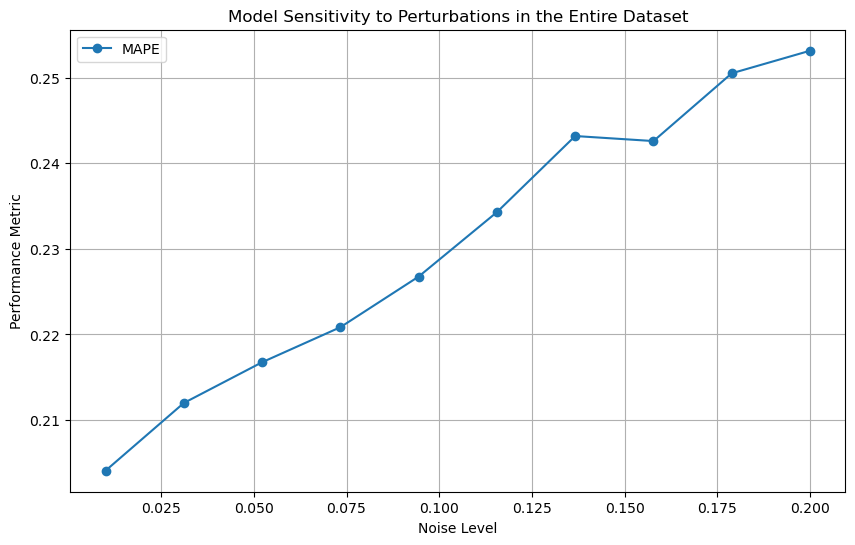

[0.10189472 0.06693544 0.05040736 0.00449597 0.01575644 0.02420517
 0.00821867 0.61091602 0.11717022]


0.7894651349971789

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

def gbReg(Xtrain, Xtest, ytrain, ytest):
    model=GradientBoostingRegressor()
    model.fit(Xtrain,ytrain)
    y_pred = model.predict(Xtest)
    perturbationDisplay(model, Xtest, ytest, y_pred)
    print(model.feature_importances_)
    return model.score(Xtest,ytest)

gbReg(X_train_f, X_test_f, y_train_f, y_test_f)

### XGboost

0.16722251575939434
   noise_level      MAPE
0     0.010000  0.266924
1     0.031111  0.276893
2     0.052222  0.291108
3     0.073333  0.303155
4     0.094444  0.316169
5     0.115556  0.330617
6     0.136667  0.345841
7     0.157778  0.359601
8     0.178889  0.358321
9     0.200000  0.379212


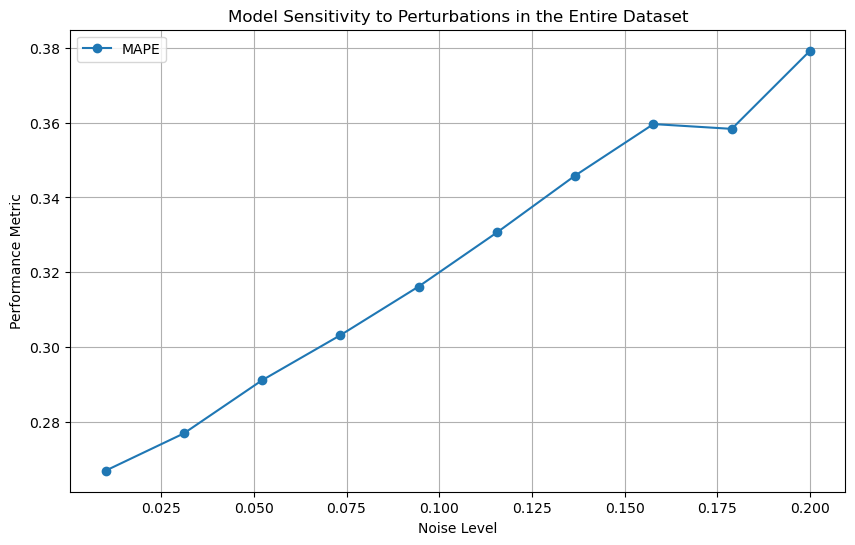

[0.06494998 0.05903829 0.04097809 0.01677116 0.03168581 0.03024098
 0.0163351  0.38031784 0.3596827 ]
30747.15985344772
2133197227.6274953
46186.54812418325
0.8427988848590376


0.8427988848590376

In [37]:
import xgboost as xgb

def xgReg(Xtrain, Xtest, ytrain, ytest):
    model = xgb.XGBRegressor()
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    perturbationDisplay(model, Xtest, ytest, y_pred)
    #xgboosty
    print(model.feature_importances_)
    performance(ytest, y_pred)
    
    return model.score(Xtest,ytest)
xgReg(X_train_f, X_test_f, y_train_f, y_test_f)

### LightGBM

In [55]:
%pip install -U "dask[dataframe]>=2023.2.0" "distributed>=2023.2.0"

  Using cached partd-1.4.2-py3-none-any.whl.metadata (4.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.2 MB/s eta 0:00:00
Using cached partd-1.4.2-py3-none-any.whl (18 kB)
  Attempting uninstall: zipp
    Found existing installation: zipp 3.8.0
    Uninstalling zipp-3.8.0:
      Successfully uninstalled zipp-3.8.0
  Attempting uninstall: zict
    Found existing installation: zict 2.1.0
    Uninstalling zict-2.1.0:
      Successfully uninstalled zict-2.1.0
  Attempting uninstall: partd
    Found existing installation: partd 1.2.0
    Uninstalling partd-1.2.0:
      Successfully uninstalled partd-1.2.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
  Attempting uninstall: dask
    Found existing installation: dask 2022.7.0
    Uninstalling da

In [38]:
import lightgbm as lgb

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 9
[LightGBM] [Info] Start training from score 206744.883947
0.18762581109598173
   noise_level      MAPE
0     0.010000  0.190087
1     0.031111  0.198778
2     0.052222  0.207277
3     0.073333  0.216219
4     0.094444  0.228602
5     0.115556  0.236639
6     0.136667  0.244033
7     0.157778  0.249361
8     0.178889  0.262836
9     0.200000  0.261154


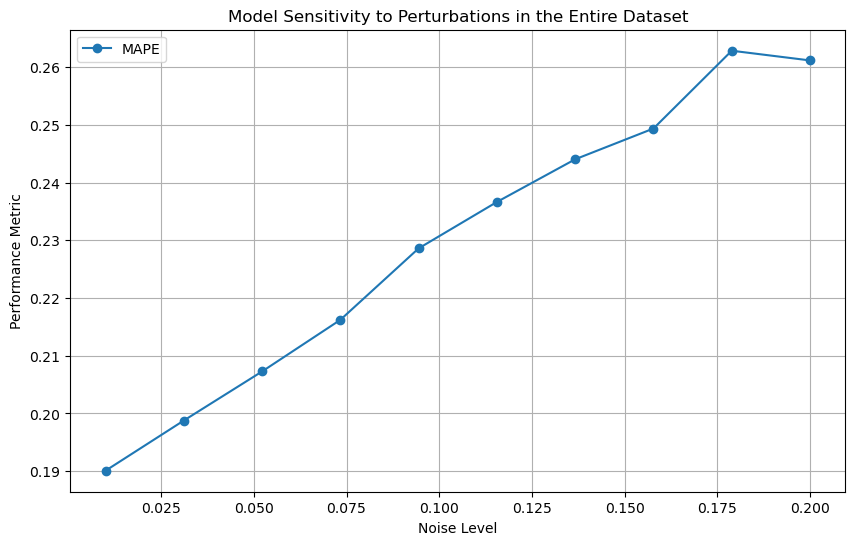

33577.43720940611
2370631340.41509
48689.12959188211
0.8234721115704037


In [39]:
def lgbReg(Xtrain, Xtest, ytrain, ytest):
    train_data = lgb.Dataset(Xtrain, label=ytrain)
    valid_data = lgb.Dataset(Xtest, label=ytest, reference=train_data)
    params = {
    'objective': 'regression',
    'metric': 'l2',  # or 'rmse', 'mae', etc.
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
    }
    num_round = 100
    model = lgb.train(params, train_data, num_round, valid_sets=[valid_data])
    
    y_pred = model.predict(Xtest)
    perturbationDisplay(model, Xtest, ytest, y_pred)
    performance(ytest, y_pred)
    return

lgbReg(X_train, X_test, y_train, y_test)

## Regression Evaluation

In [41]:
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor().fit(X_train, y_train)
gb = GradientBoostingRegressor().fit(X_train, y_train)
xg = xgb.XGBRegressor().fit(X_train, y_train)



/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/Users/luxueqi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


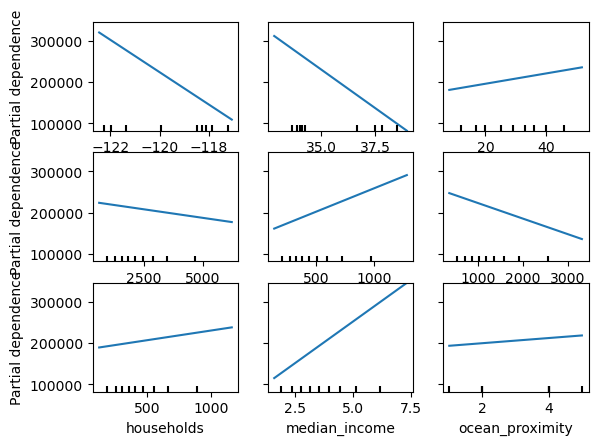

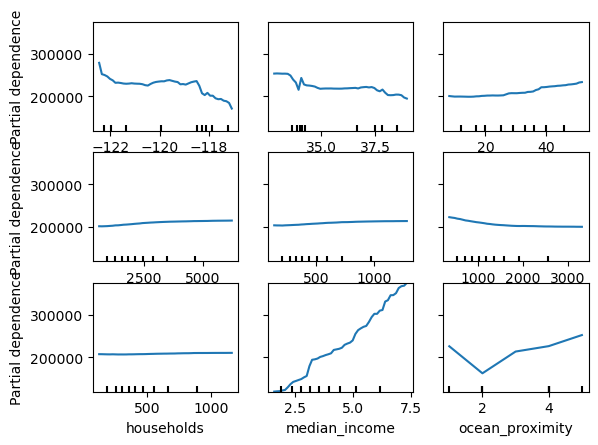

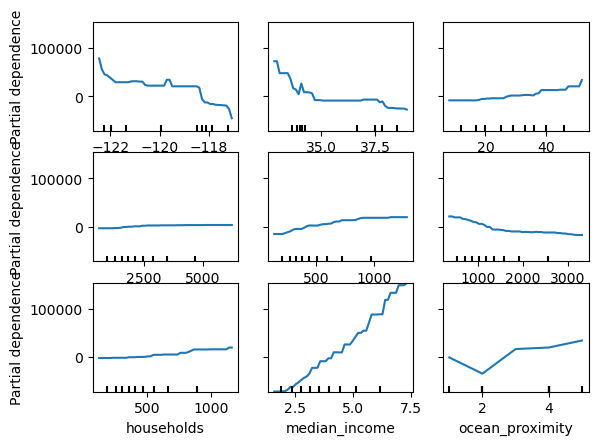

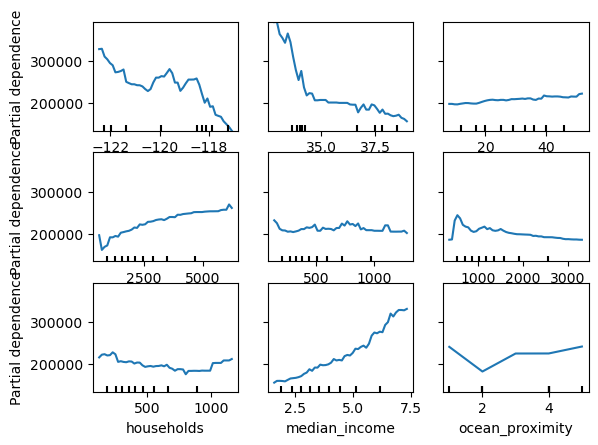

In [42]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(lr, X_train, features=[0,1,2,3,4,5,6,7,8], grid_resolution=50)
plot_partial_dependence(rf, X_train, features=[0,1,2,3,4,5,6,7,8], grid_resolution=50)
plot_partial_dependence(gb, X_train, features=[0,1,2,3,4,5,6,7,8], grid_resolution=50)
plot_partial_dependence(xg, X_train, features=[0,1,2,3,4,5,6,7,8], grid_resolution=50)

MAE (low)
MSE (low)
RMSE (low)
R^2 (high but consistent)

An R^2 of 1 indicates that the model perfectly explains the variability in the dependent variable.
An R^2 of 0 indicates that the model does not explain any of the variability in the dependent variable.

Overfitting: A very high R^2 on training data but much lower R^2 on test data can indicate overfitting.(test???)

MAPE

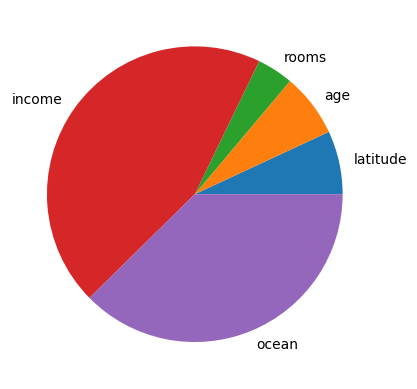

In [45]:
y = np.array([0.07, 0.07, 0.04, 0.45,  0.38])
mylabels = ["latitude", "age", "rooms","income","ocean"]

plt.pie(y, labels = mylabels)
plt.show() 

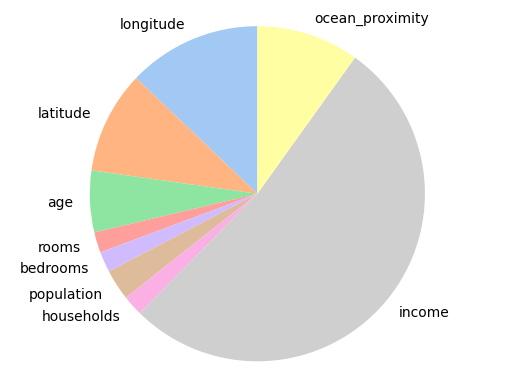

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['longitude', 'latitude', 'age', 'rooms', 'bedrooms', 'population', 'households', 'income', 'ocean_proximity']
sizes = [0.13, 0.10, 0.06, 0.02, 0.02, 0.03, 0.02, 0.53, 0.10]

colors = sns.color_palette('pastel')[0:9]
plt.pie(sizes, labels=labels, colors=colors, startangle=90)
plt.axis('equal')
plt.show()

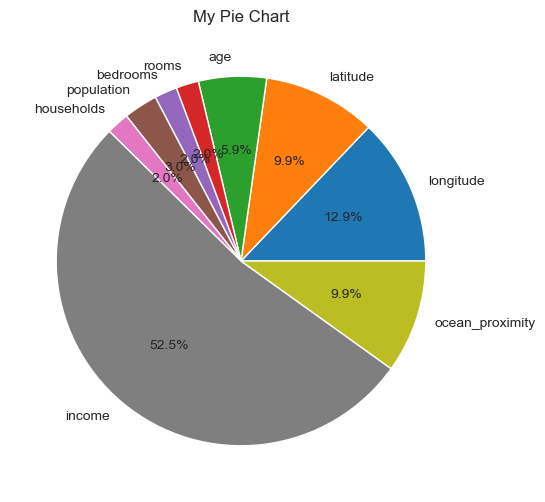

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("whitegrid")
sns.color_palette("flare", as_cmap=True)
data = {'labels': ['longitude', 'latitude', 'age', 'rooms', 'bedrooms', 'population', 'households', 'income', 'ocean_proximity'],
        'values': [0.13, 0.10, 0.06, 0.02, 0.02, 0.03, 0.02, 0.53, 0.10]}
df = pd.DataFrame(data)
plt.figure(figsize=(6,6))
plt.pie(df['values'], labels=df['labels'], autopct='%1.1f%%')
plt.title('My Pie Chart')
plt.show()